In [12]:
# Re-import required modules due to kernel reset
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab, attr="LEMMA")

# Define features
FEATURES = {
    "camera": ["camera", "photo", "picture"],
    "battery": ["battery", "charge", "charging"],
    "performance": ["performance", "speed", "lag", "slow", "smooth"],
    "display": ["screen", "display", "resolution"],
    "sound": ["sound", "speaker", "audio"],
    "design": ["design", "look", "build", "style"],
    "price": ["price", "cost", "expensive", "cheap", "value"]
}
for feature, terms in FEATURES.items():
    matcher.add(feature, [nlp(term) for term in terms])

# Sentiment words
positive_words = {"good", "great", "excellent", "amazing", "awesome", "fantastic", "positive", "smooth"}
negative_words = {"bad", "terrible", "poor", "awful", "slow", "negative", "laggy", "issue", "problem"}
contrastive = {"but", "however", "although", "yet"}

# Analysis function
def extract_aspect_sentiment(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    results = {}
    for match_id, start, end in matches:
        span = doc[start:end]
        feature = nlp.vocab.strings[match_id]
        sent = span.sent
        sent_words = {token.lemma_ for token in sent}
        polarity = "NEUTRAL"
        if sent_words & positive_words:
            polarity = "POSITIVE"
        if sent_words & negative_words:
            polarity = "NEGATIVE"
        if polarity != "NEUTRAL":
            results[feature] = polarity
    return results

print("🔧 Environment reloaded successfully.")


🔧 Environment reloaded successfully.


In [14]:
# Step 2: Load dataset and apply sentiment analysis to first 5,000 reviews
import pandas as pd
from tqdm import tqdm

csv_path = r"C:\Users\thund\OneDrive\Desktop\sentiment analysis from reviews\Prediction.csv"

# Load only required columns and limit to first 5000 rows
df = pd.read_csv(csv_path, encoding='latin1', usecols=["Cleaned Review"], nrows=5000)

# Drop rows where 'extract' is missing
df.dropna(subset=["Cleaned Review"], inplace=True)
df.reset_index(drop=True, inplace=True)

# Run aspect-based sentiment extraction
tqdm.pandas()
df["aspect_sentiments"] = df["Cleaned Review"].progress_apply(extract_aspect_sentiment)

print("✅ Aspect-based sentiment extraction complete.")


100%|██████████| 875/875 [00:14<00:00, 58.39it/s]

✅ Aspect-based sentiment extraction complete.


Overall Sentiment Counts:
sentiment
POSITIVE    749
NEGATIVE    709
Name: count, dtype: int64


C:\Users\thund\AppData\Local\Temp\ipykernel_35640\2693938529.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=sentiment_df, palette="Set2")


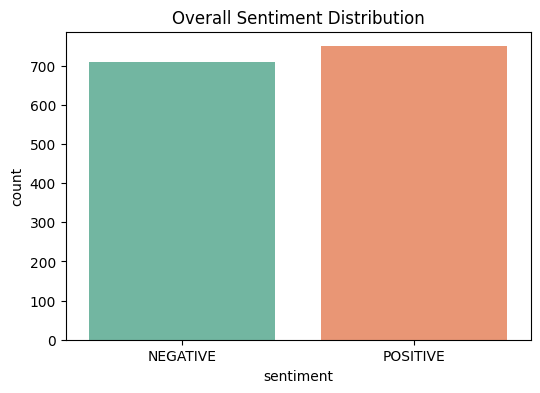

In [17]:
# Flatten all feature sentiments into a single list
all_sentiments = []

for aspects in df["aspect_sentiments"]:
    for feat, senti in aspects.items():
        all_sentiments.append((feat, senti))

# Convert to DataFrame
sentiment_df = pd.DataFrame(all_sentiments, columns=["feature", "sentiment"])

# Overall sentiment count
overall_counts = sentiment_df["sentiment"].value_counts()
print("Overall Sentiment Counts:")
print(overall_counts)

# Save to CSV
overall_counts.to_frame(name="count").to_csv("overall_sentiment_counts.csv")

# Plot overall sentiment
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=sentiment_df, palette="Set2")
plt.title("Overall Sentiment Distribution")
plt.show()



Feature-wise Sentiment Counts:
sentiment    NEGATIVE  POSITIVE
feature                        
battery           126       127
camera            152       173
design             67        93
display           105       117
performance       130        86
price              70       108
sound              59        45


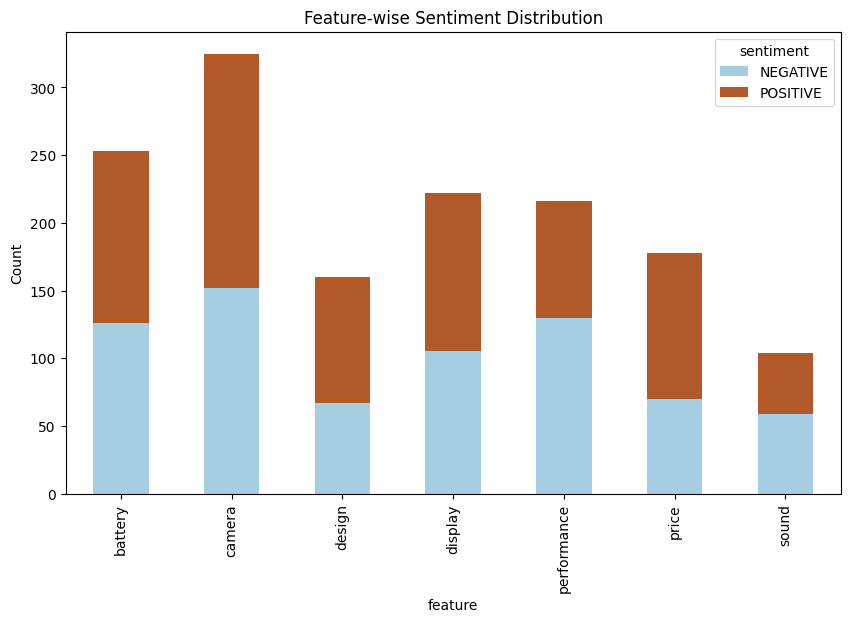

In [18]:
# Feature-wise sentiment count
feature_counts = sentiment_df.groupby(["feature", "sentiment"]).size().unstack().fillna(0)

print("Feature-wise Sentiment Counts:")
print(feature_counts)

# Plot
feature_counts.plot(kind="bar", stacked=True, figsize=(10,6), colormap="Paired")
plt.title("Feature-wise Sentiment Distribution")
plt.ylabel("Count")
plt.show()

# Save feature-wise sentiment counts to CSV
feature_counts.to_csv("feature_wise_sentiment_counts.csv")


